# Data Understanding
Este notebook refere-se à etapa de entendimento dos dados do [Quati Dataset](https://huggingface.co/datasets/unicamp-dl/quati) utilizado no projeto do **RAG-BR**, contemplando os passos:
- Coleta dos dados
- Limpeza inicial
- Análise exploratória

Ao final, os dados pré-processados são salvos em formato `parquet` para as etapas futuras.

## Importações e instalações

> **Obs.:** A versão mais recente da biblioteca `datasets` (>4.0.0) do HuggingFace removeu o suporte para o carregamento de conjuntos de dados que dependem de scripts Python remotos por razões de segurança. O dataset Quati ainda utiliza um desses scripts (quati.py) para processar e carregar os dados. Desta forma, foi necessário instalar uma versão anterior da biblioteca para carregar os dados do dataset (baixar os dados diretamente do repositório seria outra alternativa).

In [1]:
# Instalações
!pip install "datasets<4.0.0"
!pip install -U spacy   # NLP
!python -m spacy download pt_core_news_sm
!pip install pandarallel    # Paralelização no Pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 31.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Imports
# Utils
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Manipulação de dados
import pandas as pd
from datasets import load_dataset
from pandarallel import pandarallel
pd.set_option("display.width", 120)
pandarallel.initialize(nb_workers=os.cpu_count(), progress_bar=True)

# Visualização gráfica
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
sns.set_palette('mako')
sns.color_palette('mako', as_cmap=True)

# NLP (limpeza e processamento textual básico)
import re
import spacy
import unicodedata

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Coleta dos dados
O dataset encontra-se disponível através do HuggingFace e está atualmente disponível em duas versões: uma com 1 milhão de passagens (`quati_1M_passages`) e outra maior, com 10 milhões de passagens (`quati_10M_passages`). Por questões de praticidade e limtação computacional, foi utilizado o `quati_1M_passages`.

O dataset possui três tabelas:
- `Passages`: Tabela contendo os documentos para Recuperação de Informação.
- `Qrels`: Tabela contendo as relações e os scores (de 0 a 3) entre as consultas e os documentos.
- `Topics`: Tabela contendo consultas/perguntas para corresponder com os documentos.

### `passages` - Tabela de documentos/passagens

In [3]:
# Load passages
passages_dataset = load_dataset("unicamp-dl/quati", "quati_1M_passages", trust_remote_code=True)

passages_dataset

DatasetDict({
    quati_1M_passages: Dataset({
        features: ['passage_id', 'passage'],
        num_rows: 1000000
    })
})

In [4]:
# Convert dataset into pandas dataframe
passages_df = passages_dataset["quati_1M_passages"].to_pandas()

passages_df.head()

,passage_id,passage
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na..."
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ..."
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...


In [5]:
# Display dataset info
passages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   passage_id  1000000 non-null  object
 1   passage     1000000 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


### `qrels` - Tabela de correspondência entre consultas e documentos

In [6]:
# Load qrels
qrels_dataset = load_dataset("unicamp-dl/quati", "quati_1M_qrels", trust_remote_code=True)

qrels_dataset

DatasetDict({
    quati_1M_qrels: Dataset({
        features: ['query_id', 'passage_id', 'score'],
        num_rows: 1933
    })
})

In [7]:
# Convert dataset into a dataframe
qrels_df = qrels_dataset["quati_1M_qrels"].to_pandas()

qrels_df.head()

,query_id,passage_id,score
0,1,clueweb22-pt0000-78-09747_0,1
1,1,clueweb22-pt0000-96-07278_111,1
2,1,clueweb22-pt0001-85-06153_3,1
3,1,clueweb22-pt0000-64-06285_35,2
4,1,clueweb22-pt0000-87-13049_0,0


In [8]:
# Display dataset info
qrels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933 entries, 0 to 1932
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    1933 non-null   int32 
 1   passage_id  1933 non-null   object
 2   score       1933 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 30.3+ KB


In [9]:
# Count scores
qrels_df["score"].value_counts()

,count
score,
0,1039
1,388
2,318
3,188


### `topics` - Tabela de consultas/tópicos

In [10]:
# Load topics
topics_dataset = load_dataset("unicamp-dl/quati", "quati_all_topics", trust_remote_code=True)

topics_dataset

DatasetDict({
    quati_all_topics: Dataset({
        features: ['query_id', 'query'],
        num_rows: 200
    })
})

In [11]:
# Convert dataset into a dataframe
topics_df = topics_dataset["quati_all_topics"].to_pandas()

topics_df.head()

,query_id,query
0,0,Qual a maior característica da flora brasileira?
1,1,Qual a maior característica da fauna brasileira?
2,2,Por que os países Guiana e Suriname não são fi...
3,3,Por que a Bolívia tem duas capitais?
4,4,Qual o que significa decolonialidade?


In [12]:
# Display dataset info
topics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query_id  200 non-null    int32 
 1   query     200 non-null    object
dtypes: int32(1), object(1)
memory usage: 2.5+ KB


## Limpeza inicial e verificações iniciais
A limpeza inicial aqui aplicada consiste na eliminação de ruídos e padronização na formatação dos textos que podem distorcer a análise textual. Para isso, foram utilizadas de técnicas básicas de **Processamento de Linguagem Natural** (NLP) através da biblioteca spaCy.

Após a limpeza inicial, foi feito uma verificação inicial do conjunto de dados para observar:
- A presença de textos vazios
- A presença de textos duplicados (ou "quase" duplicados) através de hash

In [13]:
# Clean text function
# TODO: Refazer a limpeza inicial utilizando Datasets no lugar de Pandas
#       Para otimização com paralelismo e para melhores resultados
nlp = spacy.load("pt_core_news_sm", disable=["ner", "parser", "lemmatizer"])
def clean_text(text: str) -> str:
    """
    Realiza limpeza de ruídos e padroniza a formatação do textual através do spaCy.
    Remove:
        - Texto em HTML
        - Múltiplos espaços
        - Caractéres estranhos

    Params:
        text (str): Texto com ruídos
    Returns:
        str: Texto formatado e limpo
    """
    if not text:
        return ""

    text = unicodedata.normalize("NFKC", text)

    # Remove HTML
    text = re.sub(r"<[^>]+>", " ", text)

    # Tokenize
    doc = nlp(text)

    tokens = []
    for t in doc:
        if t.is_space or t.is_punct:
            continue
        tokens.append(t.text.lower())

    return " ".join(tokens)


In [14]:
# Clean text function
def clean_text_regex(text: str) -> str:
    """
    Realiza limpeza de ruídos e padroniza a formatação do textual através de regex.
    Remove:
        - Texto em HTML
        - Múltiplos espaços
        - Caractéres estranhos

    Params:
        text (str): Texto com ruídos
    Returns:
        str: Texto formatado e limpo
    """
    if text is None:
        return ""

    clean_text = unicodedata.normalize("NFKC", text)

    # Remove HTML
    clean_text = re.sub(r"<[^>]+>", " ", clean_text)

    # Remove multiple spaces
    clean_text = re.sub(r"\s+", " ", clean_text)

    # Remove strange characters
    clean_text = clean_text.replace("\x00", " ")

    return clean_text.strip().lower()

### Verificação inicial em `passages`

In [15]:
# Applying text cleanup on passages
# passages_df["clean_passage"] = passages_df["passage"].apply(clean_text)

# Parallelized: for using with pandas and spacy
# This isn't the best choice, due to pandas limitation (best choice: use Datasets)
passages_df["clean_passage"] = passages_df["passage"].parallel_apply(clean_text) # Parallelized

passages_df[["passage", "clean_passage"]].head()

,passage,clean_passage
0,"Se você precisar de ajuda, visite o website na...",se você precisar de ajuda visite o website nac...
1,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...
2,"""O Casino Estoril fica localizado no Estoril, ...",o casino estoril fica localizado no estoril a ...
3,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...
4,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...


In [16]:
# Verify empty strings on passages
null_passages = passages_df[passages_df["clean_passage"] == ""]

if len(null_passages) == 0:
    print("Sem documentos vazios.")
else:
    print(f"Quantidade de documentos vazios: {len(null_passages)}")
    null_passages.head()

Sem documentos vazios.


In [17]:
# Verify duplicates or almost-duplicates passages
passages_df["hash"] = passages_df["clean_passage"].apply(lambda x: hash(x))
passages_df["hash"].value_counts().head()

,count
hash,
4161715137179816491,5
-3444418471003015496,4
8065285555674666450,4
671113561688736075,4
6013780956688585721,3


### Verificação inicial em `topics`

In [18]:
# Applying text cleanup on topics
topics_df["clean_query"] = topics_df["query"].apply(clean_text)

topics_df[["query", "clean_query"]].head()

,query,clean_query
0,Qual a maior característica da flora brasileira?,qual a maior característica da flora brasileira
1,Qual a maior característica da fauna brasileira?,qual a maior característica da fauna brasileira
2,Por que os países Guiana e Suriname não são fi...,por que os países guiana e suriname não são fi...
3,Por que a Bolívia tem duas capitais?,por que a bolívia tem duas capitais
4,Qual o que significa decolonialidade?,qual o que significa decolonialidade


In [19]:
# Verify empty strings on queries
null_topics = topics_df[topics_df["clean_query"] == ""]
if len(null_topics) == 0:
    print("Sem consultas vazias.")
else:
    print(f"{len(null_topics)} consultas vazias encontradas.")
    null_topics.head()

Sem consultas vazias.


In [20]:
# Verify duplicates or almost-duplicates passages
topics_df["hash"] = topics_df["clean_query"].apply(lambda x: hash(x))
topics_df["hash"].value_counts().head()

,count
hash,
-5163453017681394441,1
-1208947601440605981,1
-4396899460369279307,1
4882929639383013910,1
667515522564209502,1


## Análise exploratória

### Distribuição do tamanho dos textos
Utilizado para avaliar a quantidade de palavras em cada documento. Essa análise é útil para:
- Entender se o modelo deve ser robusto a micro-queries; observa-se que as queries tem entre 4 a 16 palavras.
- Identificar a proporção de documentos _heavy tails_, muito longos, observa-se que os documentos possuem entre 50 a 300 palavras.
- Avaliar a quantidade de tokens que podem ser passados via LLM.

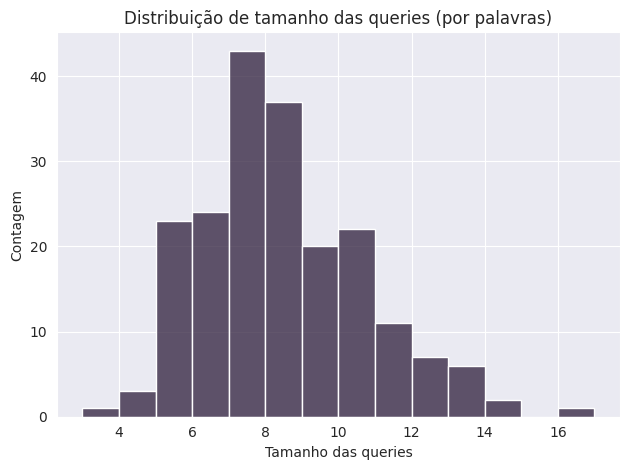

In [21]:
# Plot length of queries distribution
topics_df["len"] = topics_df["clean_query"].str.split().apply(len)

ax = sns.histplot(topics_df["len"])
ax.set_title("Distribuição de tamanho das queries (por palavras)")
ax.set_xlabel("Tamanho das queries")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

In [22]:
# Display queries too short
topics_df.loc[topics_df["len"] < 2, ["query", "clean_query", "len"]].head()

,query,clean_query,len


In [23]:
# Display queries too large
topics_df.loc[topics_df["len"] > 40, ["query", "clean_query", "len"]].head()

,query,clean_query,len


> Obs.: Foram encontrados certos obstáculos para calcular o tamanho dos documentos através do split dos documentos nos espaços, o que causou um overload na memória RAM. Desta forma, para definir o tamanho dos documentos, foi calculado a quantidade de espaços presentes no documento.

In [24]:
# Get the length of the documents more memory-efficiently
# Count spaces and add 1 for each word. Handle empty strings separately.
passages_df["len"] = passages_df["clean_passage"].str.count(' ') + 1
# For truly empty strings, the word count should be 0, not 1
passages_df.loc[passages_df["clean_passage"] == "", "len"] = 0

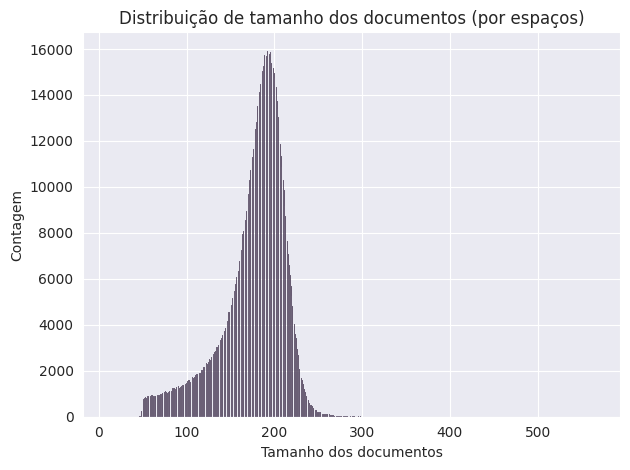

In [25]:
# Plot length of passages distribution
ax = sns.histplot(passages_df["len"])
ax.set_title("Distribuição de tamanho dos documentos (por espaços)")
ax.set_xlabel("Tamanho dos documentos")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

In [26]:
# Verify the documents too large (outliers)
# Calculate the 99th percentile for document length
length_99th_percentile = passages_df["len"].quantile(0.99)

# Filter for documents with length above the 99th percentile and sort them in descending order
outlier_passages = passages_df[passages_df["len"] > length_99th_percentile].sort_values(by="len", ascending=False)

# Display the top 10 longest outlier documents
print(f"Quantidade de documentos acima do quantil 99: {len(outlier_passages)}")
print(f"Tamanho do menor documento acima do quantil 99: {min(outlier_passages["len"])}")
outlier_passages.head(10)[["len", "passage", "clean_passage"]]

Quantidade de documentos acima do quantil 99: 9259
Tamanho do menor documento acima do quantil 99: 237


,len,passage,clean_passage
507924,566,=========================================== Ma...,= = = = = = = = = = = = = = = = = = = = = = = ...
507923,512,=========================================== E ...,= = = = = = = = = = = = = = = = = = = = = = = ...
671308,439,Exercícios de Sintaxe | PDF | Assunto (Gramáti...,exercícios de sintaxe | pdf | assunto gramátic...
723717,430,fNao ha como implantarmos o reino de Deus aqui...,fnao ha como implantarmos o reino de deus aqui...
521075,428,MODELAGEM E MAPA DE AGENCIA DE EMPREGO (EXCLUS...,modelagem e mapa de agencia de emprego exclusi...
805633,423,"""=============================================...",= = = = = = = = = = = = = = = = = = = = = = = ...
643947,421,Estão disponíveis nos vídeos os resultados da ...,estão disponíveis nos vídeos os resultados da ...
805634,417,"""\""""SUBSTITUIÇÃO PARCIAL DO AGREGADO GRAÚDO PO...","\""""substituição parcial do agregado graúdo por..."
686119,391,"""Se estiver com o Editor de Paletas aberto, ap...",se estiver com o editor de paletas aberto apon...
799364,388,Cor: Vermelho: Dimensões e Especificações Técn...,cor vermelho dimensões e especificações técnic...


### Relação de documentos com queries
Nesta análise, exploramos a relação entre as queries e os documentos. Para isso, foram visualizados:
- Quantidade de documentos com queries
- Quantidade de queries com documentos
- Distribuição de documentos por query
- Distribuição de scores de relevância


A partir das análises, foi possível verificar que:
- A maioria dos documentos não possuem uma query; existem 998.104 documentos sem consulta.
- Das 200 queries disponíveis no conjunto de dados de queries, apenas 50 possuem alguma relação (`qrel`) com os documentos; ou seja, 150 consultas sem relação com documentos.
- Em relação à distribuição das queries relacionadas com documentos, existem entre 20 e 60 documentos por query
- A distribuição de scores (relação query X passage) está distribuída de 0 a 3, sendo a maioria deles (1039 de 1933 scores) estão valoradas como 0, ou seja, a query não tem relevância com o documento relacionado.

Isso diminui, e muito, a quantidade de dados úteis para treinamento do reranker, visto que a maioria dos documentos e queries ainda não possuem uma relação de score. Além disso, a distribuição de scores aponta que a maioria das consultas possuem 0 de relevância para os documentos relacionados.

In [27]:
# Verify how much documents without a query
non_query_docs = passages_df[~passages_df['passage_id'].isin(qrels_df['passage_id'])]

print(f"Quantidade de documentos sem query: {len(non_query_docs)}.")
non_query_docs.head()

Quantidade de documentos sem query: 998104.


,passage_id,passage,clean_passage,hash,len
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na...",se você precisar de ajuda visite o website nac...,8974892268293289977,204
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...,-9080607455828696856,196
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ...",o casino estoril fica localizado no estoril a ...,-5944990594989742951,145
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...,-8001381970818504656,164
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...,1701857410400450253,186


In [28]:
# Verify how much queries without documents
non_doc_queries = topics_df[~topics_df['query_id'].isin(qrels_df['query_id'])]

print(f"Quantidade de queries sem documentos: {len(non_doc_queries)}.")
non_query_docs.head()

Quantidade de queries sem documentos: 150.


,passage_id,passage,clean_passage,hash,len
0,clueweb22-pt0000-00-00003_1,"Se você precisar de ajuda, visite o website na...",se você precisar de ajuda visite o website nac...,8974892268293289977,204
1,clueweb22-pt0000-00-00003_2,Qual a parada final de Sintra para Cascais ôni...,qual a parada final de sintra para cascais ôni...,-9080607455828696856,196
2,clueweb22-pt0000-00-00003_3,"""O Casino Estoril fica localizado no Estoril, ...",o casino estoril fica localizado no estoril a ...,-5944990594989742951,145
3,clueweb22-pt0000-00-00003_5,Sintra para Lisboa Sintra para Óbidos Leiria P...,sintra para lisboa sintra para óbidos leiria p...,-8001381970818504656,164
4,clueweb22-pt0000-00-00008_0,Iniciar a digitalização Iniciar a digitalizaçã...,iniciar a digitalização iniciar a digitalizaçã...,1701857410400450253,186


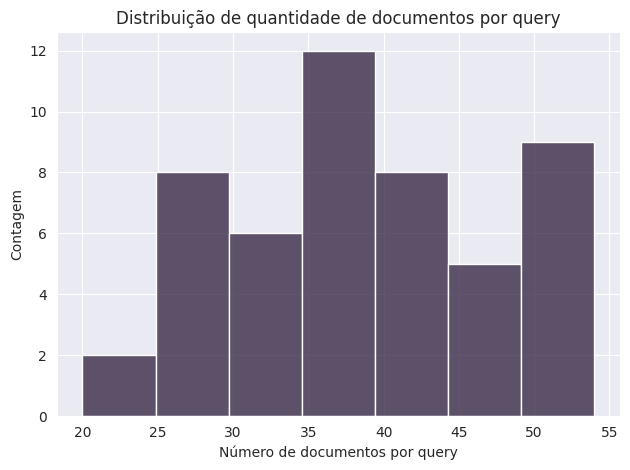

,passage_id
count,50.000000
mean,38.660000
std,8.968448
min,20.000000
25%,31.500000
50%,38.500000
75%,45.750000
max,54.000000


In [29]:
# Count document relevance score by query
rels_count = qrels_df.groupby("query_id")["passage_id"].count()

ax = sns.histplot(rels_count)
ax.set_title("Distribuição de quantidade de documentos por query")
ax.set_xlabel("Número de documentos por query")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()

rels_count.describe()

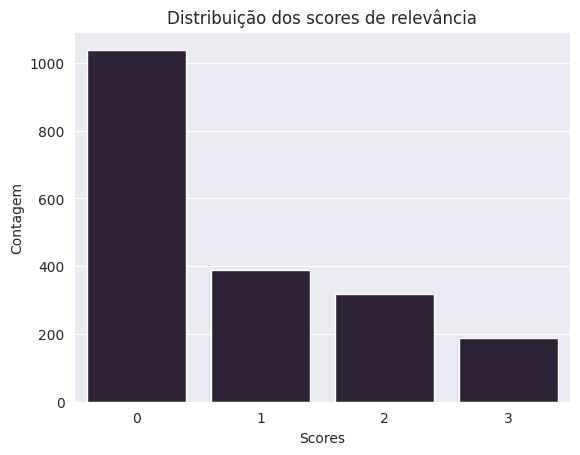

In [30]:
# Plot distribuition of scores
ax = sns.countplot(data=qrels_df, x="score")
ax.set_title("Distribuição de scores de relevância")
ax.set_xlabel("Scores")
ax.set_ylabel("Contagem")

plt.title("Distribuição dos scores de relevância")
plt.show()

### Amostras qualitativas
Abaixo, apresentamos uma amostra qualitativa dos dados. A partir de uma query filtrada e randomicamente selecionada, apresentamos a consulta e alguns dos documentos relacionados.

Desta forma, é possível avaliar qualitativamente os textos das consultas e dos documentos, bem como interpretar melhor o score de relevância (relação entre as consultas e os documentos).

In [31]:
# Function to display documents X query sample
def display_sample(score_filter: int):
    """
    Displays a query sample with its documents (up to 10).

    Params:
        score_filter (int): Score to filter the sample
    """
    # Get randomly a query with the score filter
    sample_q = random.choice(qrels_df.loc[qrels_df["score"] == score_filter, "query_id"].tolist())
    sample = qrels_df[qrels_df['query_id'] == sample_q]

    # Get query
    query = topics_df.loc[topics_df["query_id"] == sample_q, "query"]

    # Get docs
    docs_rel = passages_df[passages_df["passage_id"].isin(sample["passage_id"])]

    # Display sample
    print(f"Apresentando amostra com {score_filter} de score de relevância")
    print(f"Consulta: {query.values[0]}")
    print("Documentos:\n")
    for _, row in docs_rel.head(5).iterrows():
        print(row["passage"][:300])
        print("-" * 300, "\n")

In [32]:
# Display a query X passage sample (with score of 3)
display_sample(3)

Apresentando amostra com 3 de score de relevância
Consulta: Como configurar uma linguagem do teclado windowns 10?
Documentos:

Olá Kelvem, na verdade é apenas uma questão de configuração das opções de região e idioma do Windows 7 e não necessariamente driver do teclado. Para isso vá no Painel de Controle. Se estiver organizado por categorias clique em Alterar os Teclados ou Outros Métodos de Entrada e na janela que abrir no
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

Transferir o language pack para voz Transferir o language pack para voz Windows 10 Cortana Para alguns idiomas, poderá ter de transferir manualmente um pacote de voz. Aceda a Iniciar e abra Definições . Selecione Hora e idioma > Idioma. Selecione o idioma ao qual prete

In [33]:
# Display a query X passage sample (with score of 0)
display_sample(0)

Apresentando amostra com 0 de score de relevância
Consulta: Quais as causas para lábios inflamados em crianças?
Documentos:

Prepúcio inflamado: tratamento e causas Prepúcio inflamado: tratamento e causas Avaliação: 4,7 (6 votos) 17 comentários Por Redação ONSalus. Atualizado: 27 fevereiro 2018 Qualquer anomalia ou condição no pênis é algo muito preocupante para os homens. Embora a primeira explicação que passa pela cabeç
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ 

A causa mais comum para esse problema encontra-se na boca e podem ser várias: restaurações antigas; dentes fraturados; abscessos agudos ou crônicos; infecções ou inflamações gengivais; cárie infiltrada. As causas ainda podem se dividir em grupos devido à grande variedade

### Overlap léxico entre consultas e documentos
Esta análise se torna essencial para verificar se a relação dos dados do dataset é *lexical-heavy* ou *semantic-heavy*, ou seja, se há uma relação mais estritamente baseado em relação léxica (preponderância de palavras comuns) ou em relação semântica (preponderância de conceitos comuns).

Interpretação rápida:

- Se overlap alto → TF-IDF/BM25 funciona muito bem
- Se overlap baixo → reranker neural tem papel crítico

In [34]:
# Function to calculate lexical overlap
def lexical_overlap(q, d):
    """
    Calcula a sobreposição léxica entre a query e o documento.
    Comparação baseado no conjunto de palavras encontradas.

    Params:
        q: Query
        d: Documento
    Returns:
        float: Cálculo de sobreposição léxica
    """
    qs = set(q.split())
    ds = set(d.split())
    return len(qs & ds) / len(qs)


In [35]:
# Add query text to qrels_df
qrels_df["query_text"] = qrels_df["query_id"].apply(
    lambda x: topics_df[topics_df["query_id"] == x]["clean_query"].values[0]
)

qrels_df.head()

,query_id,passage_id,score,query_text
0,1,clueweb22-pt0000-78-09747_0,1,qual a maior característica da fauna brasileira
1,1,clueweb22-pt0000-96-07278_111,1,qual a maior característica da fauna brasileira
2,1,clueweb22-pt0001-85-06153_3,1,qual a maior característica da fauna brasileira
3,1,clueweb22-pt0000-64-06285_35,2,qual a maior característica da fauna brasileira
4,1,clueweb22-pt0000-87-13049_0,0,qual a maior característica da fauna brasileira


In [36]:
# Add passage_text to qrels_df
qrels_df["doc_text"] = qrels_df["passage_id"].apply(
    lambda x: passages_df[passages_df["passage_id"] == x]["clean_passage"].values[0]
)

qrels_df.head()

,query_id,passage_id,score,query_text,doc_text
0,1,clueweb22-pt0000-78-09747_0,1,qual a maior característica da fauna brasileira,onça-pintada escola kids qual matéria está pro...
1,1,clueweb22-pt0000-96-07278_111,1,qual a maior característica da fauna brasileira,codornas nothura minor seriemas cariama crista...
2,1,clueweb22-pt0001-85-06153_3,1,qual a maior característica da fauna brasileira,cerca de 650 espécies de aves povoam a região ...
3,1,clueweb22-pt0000-64-06285_35,2,qual a maior característica da fauna brasileira,o brasil é um país de grande extensão territor...
4,1,clueweb22-pt0000-87-13049_0,0,qual a maior característica da fauna brasileira,ecossistemas brasileiros resumo sobre as carac...


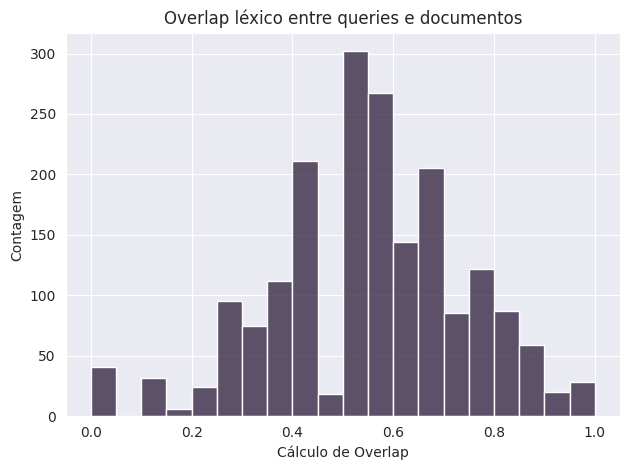

In [37]:
qrels_df["overlap"] = qrels_df.apply(lambda r: lexical_overlap(r["query_text"], r["doc_text"]), axis=1)

ax =sns.histplot(qrels_df["overlap"], bins=20)
plt.title("Overlap léxico entre queries e documentos")
ax.set_xlabel("Cálculo de Overlap")
ax.set_ylabel("Contagem")

plt.tight_layout()
plt.show()


## Guardando dados limpos
Com os dados limpos, podemos prosseguir para a etapa de preparação dos dados para a modelagem prevista. Para isso, apenas os dados necessários serão exportados em formato `parquet`, ou seja, os textos limpos (`clean_passage`, `clean_query`) e o score de relevância com a relação entre os textos (`score`).

In [38]:
# Exporting passages
# Rename column
passages_df["passage"] = passages_df["clean_passage"]

passages_df[["passage_id", "passage"]].to_parquet("passages.parquet")

In [39]:
# Exporting topics
# Rename column
topics_df["query"] = topics_df["clean_query"]

topics_df[["query_id", "query"]].to_parquet("topics.parquet")

In [40]:
# Exporting qrels
qrels_df[["query_id", "passage_id", "score"]].to_parquet("qrels.parquet")